# Audio Recognition using Tensorflow

This approach uses CNN to build a classifier for audio inputs

## Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from utils import *
from datetime import datetime
from time import time
from tensorflow.python.client import timeline # for profiling
from math import ceil

%matplotlib inline
np.random.seed(1)

## Import the dataset

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_data("../data/vectorized/90_10_split_from_train/train_sounds.h5", "../data/vectorized/90_10_split_from_train/test_sounds.h5", "../data/vectorized/90_10_split_from_train/classes_sounds.h5")

## Explore the dataset

In [3]:
X_train = X_train_orig
X_test = X_test_orig
Y_train = convert_to_one_hot(Y_train_orig, classes)
Y_test = convert_to_one_hot(Y_test_orig, classes)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 58248
number of test examples = 6473
X_train shape: (58248, 16000, 1, 1)
Y_train shape: (58248, 30)
X_test shape: (6473, 16000, 1, 1)
Y_test shape: (6473, 30)


## Create input placeholders

Tensorflow placeholders for X and Y. These will be dynamically set during batch G.D at runtime

In [4]:
def create_placeholders(n_l, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_l -- scalar, length of the audio vector
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_l] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder(tf.float32, shape=(None, n_l, 1, 1), name="X")
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name="Y")

    return X, Y

In [5]:
# X, Y = create_placeholders(500, 20)
# print ("X = " + str(X))
# print ("Y = " + str(Y))

## Initialize Parameters

With tensorflow we only need to initialize parameters for Conv layers. Fully connected layers' paramaters are completed handled by the framework.

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
    W1 : [4, 1, 1, 8]
    W2 : [2, 1, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """

    tf.set_random_seed(1)

    W1 = tf.get_variable("W1", [4,1,1,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,1,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1, "W2": W2}

    return parameters

In [7]:
# tf.reset_default_graph()
# with tf.Session() as sess_test:
#     parameters = initialize_parameters()
#     init = tf.global_variables_initializer()
#     sess_test.run(init)
#     print("W1 = " + str(parameters["W1"].eval()[0,0,0]))
#     print("W2 = " + str(parameters["W2"].eval()[0,0,0]))

## Forward Propagation

CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

Following are the parameters for all the layers:
    - Conv2D: stride 1, padding is "SAME"
    - ReLU
    - Max pool: 8 by 1 filter size and an 8 by 1 stride, padding is "SAME"
    - Conv2D: stride 1, padding is "SAME"
    - ReLU
    - Max pool: 4 by 1 filter size and a 4 by 1 stride, padding is "SAME"
    - Flatten the previous output.
    - FULLYCONNECTED (FC) layer: outputs 30 classes one for each audio utterance

In [8]:
def forward_propagation(X):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters "W1", "W2"
    the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
#     W1 = parameters['W1']
#     W2 = parameters['W2']
    regularizer1 = tf.contrib.layers.l2_regularizer(scale=0.001)
    regularizer2 = tf.contrib.layers.l2_regularizer(scale=0.01)
    regularizer3 = tf.contrib.layers.l2_regularizer(scale=0.1)
    regularizer4 = tf.contrib.layers.l2_regularizer(scale=10.0)
#     regularizer = None

    Z1 = tf.layers.conv2d(X, 8, (4,1), strides = [1,1], padding = 'SAME', kernel_regularizer = regularizer2, name="z1")
    A1 = tf.nn.relu(Z1, name="a1")
    P1 = tf.nn.max_pool(A1, ksize = [1,8,1,1], strides = [1,8,1,1], padding = 'SAME', name="p1")
    Z2 = tf.layers.conv2d(P1, 16, (2, 1), strides = [1,1], padding = 'SAME', kernel_regularizer = regularizer2, name="z2")
    A2 = tf.nn.relu(Z2, name="a2")
    P2 = tf.nn.max_pool(A2, ksize = [1,4,1,1], strides = [1,4,1,1], padding = 'SAME', name="p2")
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 30, activation_fn=None, weights_regularizer = regularizer2)

    return Z3

In [9]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     np.random.seed(1)
#     X, Y = create_placeholders(64, 5)
#     parameters = initialize_parameters()
#     Z3 = forward_propagation(X, parameters)
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     a = sess.run(Z3, {X: np.random.randn(2,64,1,1), Y: np.random.randn(2,5)})
#     print("Z3 = " + str(a))

## Compute Cost

Using the last layer Z3, compute softmax and J

In [10]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (30, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y, name="L"), name="J")

    return cost

In [11]:
# tf.reset_default_graph()
# with tf.Session() as sess:
#     np.random.seed(1)
#     X, Y = create_placeholders(64, 30)
#     parameters = initialize_parameters()
#     Z3 = forward_propagation(X, parameters)
#     cost = compute_cost(Z3, Y)
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     a = sess.run(cost, {X: np.random.randn(4,64,1,1), Y: np.random.randn(4,30)})
#     print("cost = " + str(a))

## Define Model Accuracy

In [12]:
def model_accuracy(X_train, Y_train, Z3, X, Y, minibatch_size = 64, percent_data = 100, print_progress = True):
    """
    percent_data-- approximate max % amount of data to consider while computing accuracy
    """
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    num_minibatches = 0
    acc_accuracy = 0
    total_minibatches = ceil(X_train.shape[0] / float(minibatch_size))
    max_num_minibatches = total_minibatches * percent_data / 100.0
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
    for minibatch in minibatches:
        (minibatch_X, minibatch_Y) = minibatch
        acc_accuracy += accuracy.eval({X: minibatch_X, Y: minibatch_Y})
        num_minibatches += 1
        
        if print_progress and num_minibatches % 25 == 0:
            print("%s: Accuracy after %ith batch: %f" % (datetime.now().strftime('%Y-%m-%d %H:%M:%S'), num_minibatches, acc_accuracy / num_minibatches))
        if num_minibatches >= max_num_minibatches:
            break

    train_accuracy = acc_accuracy / num_minibatches
    # print("Accuracy:", train_accuracy)

    return train_accuracy

### Plot Helper for (cost, test accuracy, train accuracy) VS (# iterations)

In [13]:
def plot_cost_test_train(num_epochs, costs, test_accs, title = ""):
    fig, ax1 = plt.subplots()
    t = np.arange(num_epochs)
    ax1.plot(t, costs, 'b-')
    ax1.set_xlabel('iterations (per tens)')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('train cost', color='b')
    ax1.tick_params('y', colors='b')

#     ax2 = ax1.twinx()
#     ax2.plot(t, training_accs, 'r-')
#     ax2.set_ylabel('train accuracy', color='r')
#     ax2.tick_params('y', colors='r')
    
    ax3 = ax1.twinx()
    ax3.plot(t, test_accs, 'm-')
    ax3.set_ylabel('test cost', color='m')
    ax3.tick_params('y', colors='m')
#     ax3.spines['right'].set_position(('axes', 1.2))

    fig.tight_layout()
#     fig.subplots_adjust(right=0.75) # add space on the right for y3 axis
    plt.title(title)
    plt.show()

## Model

Connects all the functions and sets up training with mini batches

### Start a session

In [14]:
tf.reset_default_graph() # to be able to rerun the model without overwriting tf variables

config = tf.ConfigProto(device_count = {'GPU': 0})

# Start an interactive session
sess = tf.InteractiveSession(config=config)

### Profiling

In [15]:
options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [16]:
def create_model(X_train, Y_train, learning_rate):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 16000, 1, 1)
    Y_train -- test set, of shape (None, n_y = 30)
    X_test -- training set, of shape (None, 16000, 1, 1)
    Y_test -- test set, of shape (None, n_y = 30)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    tf.set_random_seed(1) # to keep results consistent (tensorflow seed)
    (m, n_l, _, __) = X_train.shape
    n_y = Y_train.shape[1]

    X, Y = create_placeholders(n_l, n_y)
    Z3 = forward_propagation(X)
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Using AdamOptimizer to minimize the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, name="adam").minimize(cost, name="adam_minimize")
    
    streaming_cost, streaming_cost_update = tf.contrib.metrics.streaming_mean(cost)
    streaming_cost_scalar = tf.summary.scalar('streaming_cost', streaming_cost)
    # tf.summary.scalar('current_cost', cost)
    # summary = tf.summary.merge_all()

    return Z3, X, Y, cost, optimizer, streaming_cost_update, streaming_cost_scalar

In [17]:
def run_model(X_train, Y_train, X_test, Y_test, X, Y, 
              cost, optimizer, learning_rate = 0.011, minibatch_size = 64, num_epochs = 100, print_cost = True):
    
    seed = 3 # to keep results consistent (numpy seed)
    m = X_train.shape[0]
    num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
    training_costs = []
    testing_costs = []
    
    # Run the initialization
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    
    # Do the training loop
    for epoch in range(num_epochs):
        minibatch_cost = 0.
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
            _, temp_cost, _ = sess.run([optimizer, cost, streaming_cost_update], feed_dict = {X: minibatch_X, Y: minibatch_Y}) 
            minibatch_cost += temp_cost / num_minibatches

        # Print the cost every # epochs
        if print_cost == True and epoch % 10 == 0:
            print("%s: Training cost after epoch %i: %f" % (datetime.now().strftime('%Y-%m-%d %H:%M:%S'), epoch, minibatch_cost))
            training_costs.append(minibatch_cost)
            testing_summary, temp_cost = sess.run([streaming_cost_scalar, cost], feed_dict = {X: X_test, Y: Y_test})
            testing_costs.append(temp_cost)
            
            # Write to tensorboard
            training_summary = sess.run(streaming_cost_scalar)
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
        
    plot_cost_test_train(num_epochs, training_costs, testing_costs, "Learning rate = %s" % learning_rate)
    return training_costs, testing_costs

In [18]:
learning_rate = 0.001
Z3, X, Y, cost, optimizer, streaming_cost_update, streaming_cost_scalar = create_model(X_train, 
                                                                                       Y_train, 
                                                                                       learning_rate = learning_rate)

In [19]:
saver = tf.train.Saver() # create a saver for saving variables to disk

In [20]:
# Define Tensor Board Settings after creating the graph

RUN_NAME = "N: L2 0.01, alp 0.001, ep 300"
training_writer = tf.summary.FileWriter("../logs/{}/training".format(RUN_NAME), sess.graph)
testing_writer = tf.summary.FileWriter("../logs/{}/testing".format(RUN_NAME), sess.graph)

2018-01-08 03:33:20: Training cost after epoch 0: 3.220568
2018-01-08 03:47:55: Training cost after epoch 10: 2.005192
2018-01-08 04:02:34: Training cost after epoch 20: 1.583197
2018-01-08 04:17:15: Training cost after epoch 30: 1.314128
2018-01-08 04:31:54: Training cost after epoch 40: 1.128783
2018-01-08 04:46:36: Training cost after epoch 50: 0.986306
2018-01-08 05:01:17: Training cost after epoch 60: 0.869110
2018-01-08 05:15:57: Training cost after epoch 70: 0.775745
2018-01-08 05:30:37: Training cost after epoch 80: 0.694340
2018-01-08 05:45:18: Training cost after epoch 90: 0.638192
2018-01-08 05:59:58: Training cost after epoch 100: 0.590813
2018-01-08 06:14:39: Training cost after epoch 110: 0.550957
2018-01-08 06:29:19: Training cost after epoch 120: 0.505131
2018-01-08 06:43:59: Training cost after epoch 130: 0.441572
2018-01-08 06:58:39: Training cost after epoch 140: 0.474589
2018-01-08 07:13:20: Training cost after epoch 150: 0.390009
2018-01-08 07:28:01: Training cost 

ValueError: x and y must have same first dimension, but have shapes (300,) and (30,)

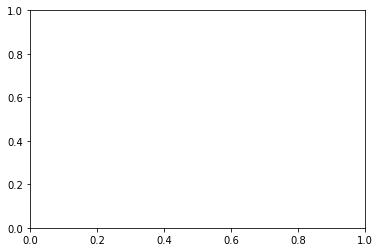

In [21]:
run_model(X_train, Y_train, X_test, Y_test, X, Y, 
          cost, optimizer, learning_rate = learning_rate,
          minibatch_size = 256, num_epochs = 300)

### Save profiling data to disk

In [ ]:
# Create the Timeline object, and write it to a json file
def save_profiling_data():
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    time_id = int(time())
    with open('../experiments/timeline_s_256b_120e_gpu0_l2_%s.json' % (time_id,), 'w') as f:
        f.write(chrome_trace)

## Save model to disk

In [22]:
saved_path = saver.save(sess, "../saved_models/l2_10_300e_256b_l2-reg-0.01_alpha-0.001.ckpt")

# meta_graph_def = tf.train.export_meta_graph(filename='../saved_models/my-cnn-tf-model.meta')

In [23]:
sess.list_devices()


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [24]:
# train accuracy
model_accuracy(X_train, Y_train, Z3, X, Y, minibatch_size = 256)

2018-01-08 11:00:02: Accuracy after 25th batch: 0.953906
2018-01-08 11:00:04: Accuracy after 50th batch: 0.955859
2018-01-08 11:00:07: Accuracy after 75th batch: 0.954427
2018-01-08 11:00:09: Accuracy after 100th batch: 0.954102
2018-01-08 11:00:11: Accuracy after 125th batch: 0.955125
2018-01-08 11:00:13: Accuracy after 150th batch: 0.956042
2018-01-08 11:00:16: Accuracy after 175th batch: 0.955826
2018-01-08 11:00:18: Accuracy after 200th batch: 0.955566
2018-01-08 11:00:20: Accuracy after 225th batch: 0.955573


0.95541977071971229

In [25]:
# test accuracy
model_accuracy(X_test, Y_test, Z3, X, Y, minibatch_size = 256)

2018-01-08 11:00:53: Accuracy after 25th batch: 0.267188


0.26850220675651842

## Inference

- Convert audio file to vector and reshape
- Do forward prop
- Find the maximal class
- Remap index to class name

In [ ]:
def inference(audio_file, Z3):
    ra = load_wav_file(os.path.abspath(audio_file))
    x = ra.reshape(1, ra.shape[0], 1, 1)
    y_hat = tf.argmax(Z3, 1)
    prediction = sess.run(y_hat, feed_dict = {X: x})
    return classes[prediction[0]]

In [ ]:
print(inference("../data/train/audio/bed/0a7c2a8d_nohash_0.wav", Z3)) # bed
print(inference("../data/train/audio/down/0a7c2a8d_nohash_0.wav", Z3)) # down
print(inference("../data/test/audio/clip_0000adecb.wav", Z3)) # happy

## Load Variables

In [ ]:
# saver = tf.train.Saver() # create a saver for saving variables to disk
# saver.restore(sess, "../saved_models/trained_model.ckpt")